## Validation analysis against open/closed cells
---------------
This notebook focuses on the validation analysis, which includes inference of trained model with lablled input data and clustering against the output of model.

-----------
### Recap: Definition of open/closed cells
we ONLY need CLEAR open and closed cells s.t. very simillar to following pictures.  
Other than these figures, we DONOT NEED them (Or, peripheral/boundary patches of these clear ones are nice to save for following analysis)

#### Open cell
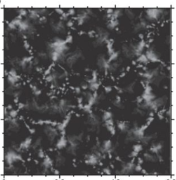
![Open]("./img/open.PNG")

##### Closed cell
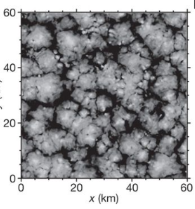
![Closed]("./img/closed.PNG")


---------------
### Prerequisites
Libraries below are necessary to download on you laptop (If disk amount is issue, we can move to Midway cluster-computer where the analysis is much easier if you have already got the access)

1. Tensorflow 1.12.0 for CPU [stackoverflow How to install CPU version of Tnesorflow](https://stackoverflow.com/questions/53614262/how-to-install-cpu-version-of-tensorflow-using-conda)
2. PySpark [pyspark](https://pypi.org/project/pyspark/)

--------------
### Load module

In [192]:
import os
import glob
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import patches as mpl_patches
import itertools
import pandas as pd
import matplotlib.patheffects as PathEffects
%matplotlib inline
import seaborn as sns

# pyspark libs
#import pyspark
#from pyspark import SparkContext 
#from pyspark.mllib.clustering import BisectingKMeans, BisectingKMeansModel

In [193]:
## directory where your put lib_hdfs
libdir='/home/rubywerman/scratch-midway2/lib_hdfs'

In [194]:
sys.path.insert(1,os.path.join(sys.path[0],libdir)) # this line helps you to use your own functions in another directory
from alignment_lib import _gen_patches
from alignment_lib import const_clouds_array
from alignment_lib import gen_mod02_img_sigle,  gen_mod35_img_single
from alignment_lib import mod02_proc_sds_single
from alignment_lib import _gen_patches
from alignment_lib import const_clouds_array

### Load Model

In [195]:
homedir = libdir
datadir = homedir+"/model/m2_02_global_2000_2018_band28_29_31"
step = 100000 # DONOT change so far

In [196]:
encoder_def = datadir+'/encoder.json'
encoder_weight = datadir+'/encoder-'+str(step)+'.h5'
with open(encoder_def, "r") as f:
    encoder = tf.keras.models.model_from_json(f.read())
encoder.load_weights(encoder_weight)

/home/rubywerman/.conda/envs/clouds/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:891: UserWarning: models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


### Load labelled open/closed cell
Tasks
1. Combine your open-notebook contents here

In [197]:
%reload_ext autoreload
%autoreload 2
from pyhdf.SD import SD, SDC

In [198]:
# directory where your put lib_hdfs
# e.g. /home/tkurihana/src/src_share/lib_hdfs
homedir='/home/rubywerman/scratch-midway2/lib_hdfs'

In [199]:
sys.path.insert(1,os.path.join(sys.path[0],homedir)) # this line helps you to use your own functinos in another directory
from alignment_lib import gen_mod02_img_sigle,  gen_mod35_img_single
from alignment_lib import mod02_proc_sds_single
from alignment_lib import _gen_patches
from alignment_lib import const_clouds_array

In [200]:
# enter name of text file containing the dates of the closed patches
closed_file_name = "/home/rubywerman/clouds/src_analysis/close_cells_mod02/close_dates.txt"
closed_text_file = open(closed_file_name, "r")
closed_dates = closed_text_file.read().split('\n')

# enter name of text file containing the dates of the open patches
open_file_name = "/home/rubywerman/clouds/src_analysis/open_cells_mod02/open_dates.txt"
open_text_file = open(open_file_name, "r")
open_dates = open_text_file.read().split('\n')

In [201]:
#select directory path for given date
def get_data(d):
    return (homedir+'/mod02/open_chile_3/' + d, homedir+'/mod35/open_chile_3/' + d, get_coded_date(d))

### Run Analysis
we will use a type of hierarchical clusering called `bisecting-kmeans` [pyspark bisecting-kmeans](https://spark.apache.org/docs/2.2.0/mllib-clustering.html#bisecting-k-means) .   

* In the case...  
If anything trouble happened, you may use another hierarchical clustering called `Agglometative clustering` . How to donwload agglomerative [sklearn aggl](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)  

`from sklearn.cluster import AgglomerativeClustering`

In [202]:
class Patch:
    def __init__(self, date, isOpen, thirtyFive, zeroTwo, label=None, feature=None):
        self.date = date
        self.isOpen = isOpen
        self.thirtyFive = thirtyFive
        self.zeroTwo = zeroTwo
        self.label = label
        self.feature = feature

In [203]:
#collect close patch 35 and 02 data
closed_patch_class_list = []
closed_clouds_mask_img_data = []
for d in closed_dates:
    if d:
        closed_date_data = np.load('/home/rubywerman/clouds/src_analysis/close_cells_mod02/closed_'+ d +'.npy')
        ccloud_img = np.load('/home/rubywerman/clouds/src_analysis/close_cells_mod35/closed_35_'+ d +'.npy')
        closed_clouds_mask_img_data.append(ccloud_img)
        for patch in closed_date_data:
            closed_patch_class_list.append(Patch(d, False, ccloud_img, patch))

In [204]:
#collect open patch 35 and 02 data
open_clouds_mask_img_data = []
open_patch_class_list = []
for d in open_dates:
    if d:
        open_date_data = np.load('/home/rubywerman/clouds/src_analysis/open_cells_mod02/open_'+ d + '.npy')
        ocloud_img = np.load('/home/rubywerman/clouds/src_analysis/open_cells_mod35/open_35_'+ d +'.npy')
        open_clouds_mask_img_data.append(ocloud_img)
        for patch in open_date_data:
            open_patch_class_list.append(Patch(d, True, ocloud_img, patch))
            

below you may create a list of patches of both open and closed patches.
you have to save where/which patches are labelled as open/closed cell.

In [205]:
# here make patches list
class_patch_list = open_patch_class_list + closed_patch_class_list

In [206]:
print("Number of patches recorded: " + str(len(class_patch_list)))

Number of patches recorded: 239


###### Inference

In [207]:
encs_list = []
for patch in class_patch_list:
    i = patch.zeroTwo
    if type(i) is not list:
        ix, iy = i.shape[:2]
        encs = encoder.predict(i.reshape(ix * iy, 128,128,6))
        encs_list += [encs.mean(axis=(1,2))]

In [208]:
features = np.concatenate(encs_list, axis=0)

In [209]:
print(features.shape)  # make sure, the shape is [#number of patches, 128]

(239, 128)


##### Clustering

In [210]:
#the first %num_open_features rows in features are open cells 
num_open_features = len(open_patch_class_list)
#starting at row %num_open_features in features they are closed cells 
num_closed_features = len(closed_patch_class_list)

In [211]:
from sklearn.cluster import AgglomerativeClustering

In [344]:
# N in [2, inf), you can change this number but save the result differently
num_clusters = 48

In [345]:
clustering = AgglomerativeClustering(num_clusters)

In [346]:
#turns any NAN values to 0 so code doesn't crash
cleaned_features = np.nan_to_num(features)

In [347]:
#generate clustering data
label = clustering.fit_predict(cleaned_features)
open_labels = label[:num_closed_features]
closed_labels = label[num_closed_features:]

In [348]:
class Cluster:
    def __init__(self, label, patches=None, means=None, std=None, num_open=0):
        self.label = label
        self.patches = patches
        self.means = means
        self.std = std
        self.num_open = num_open

        
#generates list of 6 means for each band in the patch list 
def get_band_means(patch_list):
    mean_list = []
    for i in range(6):
        mean_list.append(np.nanmean([patch.zeroTwo[0,0,:,:,:][:,:,i] for patch in patch_list]))
    return mean_list

#generates list of 6 stds for each band in the patch list 
def get_band_std(patch_list):
    std_list = []
    for i in range(6):
        std_list.append(np.nanstd([patch.zeroTwo[0,0,:,:,:][:,:,i] for patch in patch_list]))
    return std_list

In [349]:
#assign each patch instance its correct label
for i in range(len(class_patch_list)):
    class_patch_list[i].label = label[i]

In [350]:
#make a list of clusters
list_clusters = [Cluster(label=i) for i in range(num_clusters)]

In [351]:
#add patches to cluster objects
for p in class_patch_list:
    matching_cluster = list_clusters[p.label]
    if p.isOpen:
        matching_cluster.num_open += 1
    if not matching_cluster.patches:
        matching_cluster.patches = [p]
    else:
        matching_cluster.patches.append(p)

In [352]:
#add patch mean and std to cluster objects
for c in list_clusters:
    c.means = get_band_means(c.patches)
    c.std = get_band_std(c.patches)

## Visualize clustering accuracy

In [353]:
#generate number of open and closed patches in each cluster
open_clusters = [i.num_open for i in list_clusters]
closed_clusters = [len(i.patches) - i.num_open for i in list_clusters]

W0710 11:23:44.798252 140344127727424 legend.py:1282] No handles with labels found to put in legend.


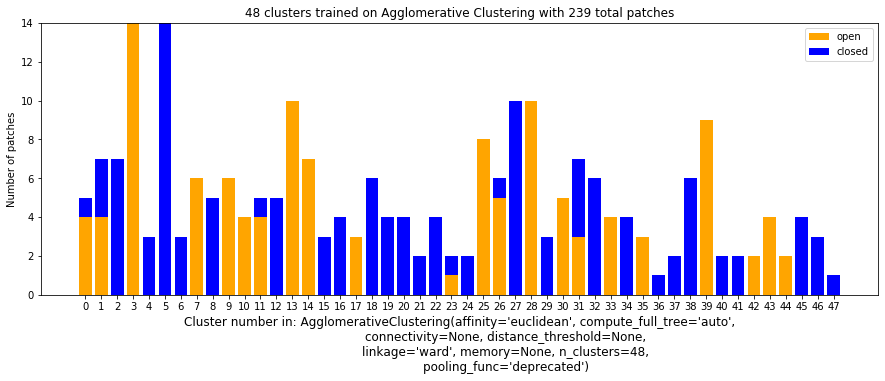

In [354]:
from matplotlib import rc
import pandas as pd

plt.figure(figsize=(15,5))

# Heights of bars
bars = [len(open_clusters), len(closed_clusters)]

# The position of the bars on the x-axis
r = range(num_clusters)
 
# Label for each bar and bar width
x_labels = [str(i) for i in r]
barWidth = .8
 
# Create open-classified bars
plt.bar(r, open_clusters, color='orange', width=barWidth)

# Stack bars
plt.bar(r, closed_clusters, bottom=open_clusters, color='blue', width=barWidth)

# label/title graph
plt.xticks(r, x_labels)
plt.ylabel("Number of patches")
plt.xlabel("Cluster number in: "+ str(clustering), fontsize=12)
plt.legend(loc="upper right")
plt.legend(('open','closed'))
plt.title("%d clusters trained on Agglomerative Clustering with %s total patches"%(num_clusters, len(label)))
plt.show()
 
# Show graphic
plt.show()

### Inspect certain clusters

In [355]:
# Utility function to visualize the outputs of t-SNE 
#takes in x, a 2d numpy array containing the output of the t-SNE algorithm and label, the 1d numpy array containing the labels of the dataset
#creates scatterplot with as many unique colors as the number of clusters
#source: https://www.datacamp.com/community/tutorials/introduction-t-sne
def cloud_scatter(x, label):
    #make a color palette with seaborn
    num_colors = len(np.unique(label))
    palette = np.array(sns.color_palette("hls", num_colors))
    
    #make scatter plot
    f = plt.figure(figsize=(15,5))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[label.astype(np.int)])
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []
    for i in range(num_colors):

        # Position of each label at median of data points.
        xtext, ytext = np.median(x[label == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=14)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        plt.title("Visualization of %d patches in %s clusters produced by t-SNE"%(len(label), num_clusters))
    return f, ax, sc, txts

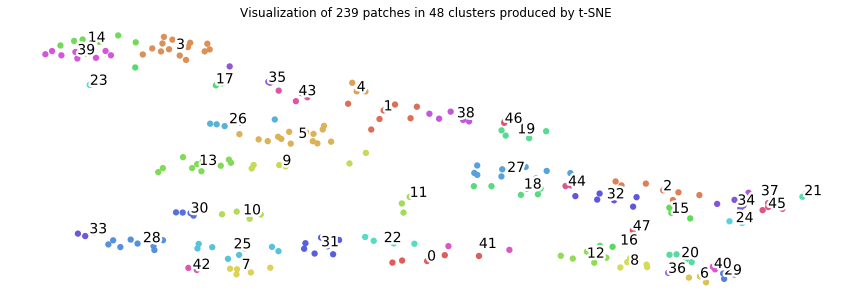

In [356]:
#visualize t-SNE 
from sklearn.manifold import TSNE
cloud_tsne = TSNE().fit_transform(cleaned_features)
plot = cloud_scatter(cloud_tsne, label)

Visuallise how open and closed clusteres are differently classified

/home/rubywerman/.conda/envs/clouds/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


<Figure size 1440x216 with 0 Axes>

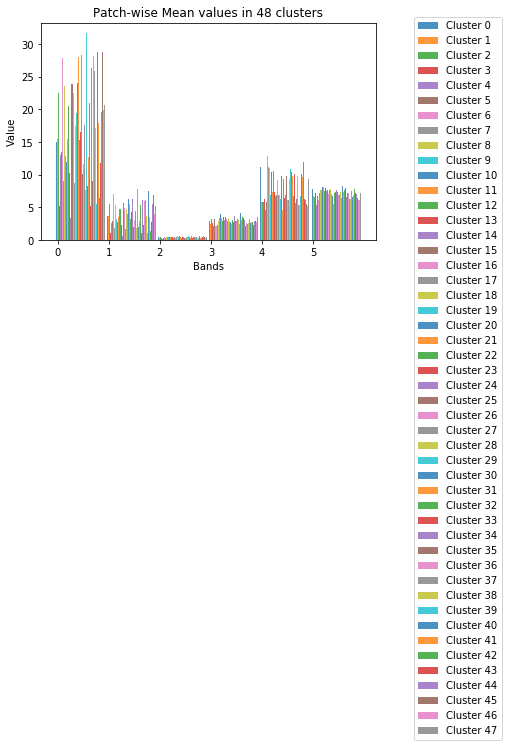

In [363]:
# data to plot
n_groups = 6

def get_cluster_means(list_clusters, i):
    return list_clusters[i].means

def get_cluster_std(list_clusters, i):
    return list_clusters[i].std

# create plot
f = plt.figure(figsize=(20,3))

fig, ax = plt.subplots()
index = 10*np.arange(n_groups)
bar_width = .2
opacity = 0.8


for i in range(num_clusters):
    plt.bar(index + bar_width*i, get_cluster_means(list_clusters,i), bar_width, 
            alpha=opacity,
            label='Cluster %d'%(i))

plt.xlabel('Bands')
plt.ylabel('Value')
plt.title('Patch-wise Mean values in %d clusters'%num_clusters)
plt.xticks(index + bar_width, range(6))
plt.legend(loc=0)
plt.legend(bbox_to_anchor=(1.1, 1.05))


plt.tight_layout()
plt.show()

/home/rubywerman/.conda/envs/clouds/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


<Figure size 1440x216 with 0 Axes>

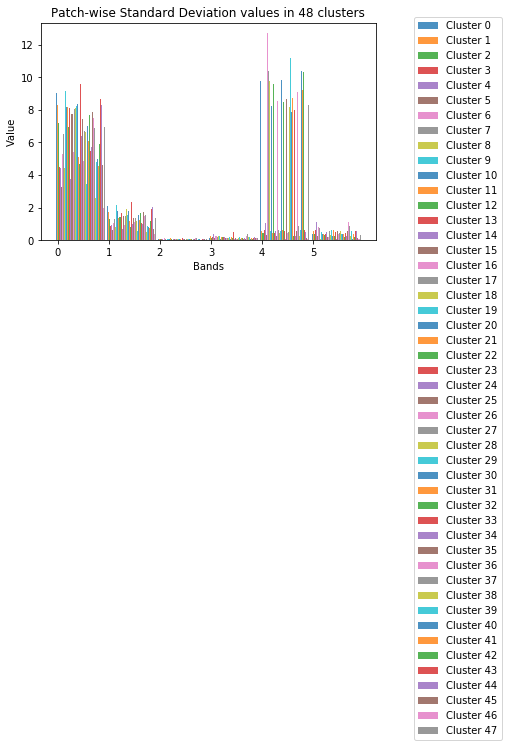

In [364]:
# data to plot
n_groups = 6

# create plot
f = plt.figure(figsize=(20,3))

fig, ax = plt.subplots()
index = 10*np.arange(n_groups)
bar_width = .2
opacity = 0.8


for i in range(num_clusters):
    plt.bar(index + bar_width*i, get_cluster_std(list_clusters,i), bar_width, 
            alpha=opacity,
            label='Cluster %d'%(i))

plt.xlabel('Bands')
plt.ylabel('Value')
plt.title('Patch-wise Standard Deviation values in %d clusters'%num_clusters)
plt.xticks(index + bar_width, range(6))
plt.legend(loc=0)
plt.legend(bbox_to_anchor=(1.1, 1.05))


plt.tight_layout()
plt.show()

In [359]:
"""
plt.scatter(cleaned_features[:,0],cleaned_features[:,1], cmap='rainbow')  
plt.xlabel("column 1 / 128 data", fontsize=20)
plt.ylabel("column 0 / 128 data", fontsize=20)
plt.title("%d clusters trained on AgglomerativeClustering "%(num_clusters))
plt.legend(fontsize=16, loc='upper left')
plt.tick_params(labelsize=18)
"""


'\nplt.scatter(cleaned_features[:,0],cleaned_features[:,1], cmap=\'rainbow\')  \nplt.xlabel("column 1 / 128 data", fontsize=20)\nplt.ylabel("column 0 / 128 data", fontsize=20)\nplt.title("%d clusters trained on AgglomerativeClustering "%(num_clusters))\nplt.legend(fontsize=16, loc=\'upper left\')\nplt.tick_params(labelsize=18)\n'

<Figure size 1080x360 with 0 Axes>

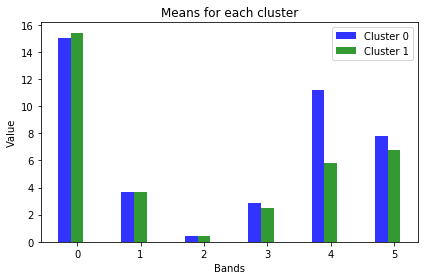

In [360]:
# data to plot
n_groups = 6
cluster_0_means = list_clusters[0].means
cluster_1_means = list_clusters[1].means

# create plot
f = plt.figure(figsize=(15,5))

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.8

rects1 = plt.bar(index, cluster_0_means, bar_width,
alpha=opacity,
color='b',
label='Cluster 0')

rects2 = plt.bar(index + bar_width, cluster_1_means, bar_width,
alpha=opacity,
color='g',
label='Cluster 1')

plt.xlabel('Bands')
plt.ylabel('Value')
plt.title('Means for each cluster')
plt.xticks(index + bar_width, range(6))
plt.legend()

plt.tight_layout()
plt.show()

W0710 11:23:51.072777 140344127727424 legend.py:1282] No handles with labels found to put in legend.


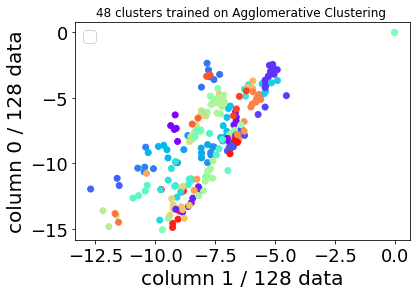

In [361]:

plt.scatter(cleaned_features[:,0],cleaned_features[:,1], c=label, cmap='rainbow')  
plt.xlabel("column 1 / 128 data", fontsize=20)
plt.ylabel("column 0 / 128 data", fontsize=20)
plt.title("%d clusters trained on Agglomerative Clustering "%(num_clusters))
plt.legend(fontsize=16, loc='upper left')
plt.tick_params(labelsize=18)